<a href="https://colab.research.google.com/github/belerico/text/blob/master/advanced%20machine%20learning/assignment%202/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [3]:
!pip install wget

import wget

wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/x_test.obj', './x_test.obj')
wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/y_train.obj', './y_train.obj')
wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/x_train.obj', './x_train.obj')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=f37c89a9505dc1c5e53ee54431836d5e1b0e12e96937ad77323ebea2666f867e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'./x_train.obj'

In [4]:
import pickle
import numpy as np
import keras
from keras import utils

with open('./x_train.obj', 'rb') as f:
  dataset = pickle.load(f)
  dataset = dataset.astype('float32') / 255.
  dataset = dataset.reshape(dataset.shape[0], -1)

with open('./x_test.obj', 'rb') as f:
  x_test = pickle.load(f)
  x_test = x_test.astype('float32') / 255.
  x_test = x_test.reshape(x_test.shape[0], -1)

with open('./y_train.obj', 'rb') as f:
  y_dataset = pickle.load(f)
  # Label from 0 to 11
  y_dataset -= 16
  # y_dataset = utils.to_categorical(y_dataset)

N_IMG = dataset.shape[0]
N_CLASSES = 11
IMG_SHAPE = dataset.shape[1]

# Split train and val
import random

indexes = np.arange(N_IMG)
# random.seed(42)
random.shuffle(indexes)
train_val_split = int(N_IMG * 0.8)

x_train = dataset[indexes[:train_val_split], :]
y_train = y_dataset[indexes[:train_val_split]]

x_val = dataset[indexes[train_val_split:], :]
y_val = y_dataset[indexes[train_val_split:]]

# Standardize to get gaussian

mean = np.mean(x_train)
std = np.std(x_train)

print(f"Mean {mean} and std {std}")

Mean 0.17235195636749268 and std 0.33112195134162903


# Data info

train size: 14000
test size: 8800
labels distribution: [(0, 1295), (1, 1265), (2, 1346), (3, 1329), (4, 1336), (5, 1297), (6, 1269), (7, 1327), (8, 1322), (9, 1321), (10, 893)]


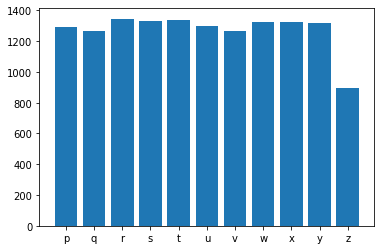

In [17]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

print('train size:', len(dataset))
print('test size:', len(x_test))
data_distribution = sorted(Counter(y_dataset).items())
print('labels distribution:', data_distribution)
x = np.arange(len(data_distribution))
plt.bar(x, height=[val for _, val in data_distribution])
plt.xticks(x, ['p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
plt.show()

## Custom layers

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K


class SaltPepperNoise(layers.Layer):
  
  def __init__(self, ratio=0.5, **kwargs):
    super(SaltPepperNoise, self).__init__(**kwargs)
    self.ratio = ratio

  # NOTE: this is the definition of the call method of custom layer class (i.e. SaltAndPepper)
  def call(self, inputs, training=None):
    def noised():
      shp = K.shape(inputs)[1:] # input shape
      mask_select = K.random_binomial(shape=shp, p=self.ratio)
      mask_noise = K.random_binomial(shape=shp, p=0.5) # salt and pepper have the same chance
      out = inputs * (1-mask_select) + mask_noise * mask_select
      return out
    
    return K.in_train_phase(noised(), inputs, training=training)
  
  
class StandardizeLayer(layers.Layer):
  
  def __init__(self, mean, std, **kwargs):
    super(StandardizeLayer, self).__init__(**kwargs)
    self.mean = mean
    self.std = std

  def call(self, inputs, training=None):
     return (inputs - self.mean) / self.std
    
    
class DenseTranspose(layers.Layer):
  
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = tf.keras.activations.get(activation)
    super().__init__(**kwargs)
  
  def build(self, batch_input_shape):
    print(self.dense.weights[0])
    self.non_trainable_weights.append(self.dense.weights[0])
    self.biases = self.add_weight(name='bias', initializer='zeros',
                                 shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
    
  def call(self, inputs):
    z = inputs @ K.transpose(self.dense.weights[0]) 
    return self.activation(z + self.biases)

# Models and training

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers


def rmse(y_true, y_pred):
  return K.sqrt(losses.mse(y_true, y_pred))


def tanh_crossentropy(y_true, y_pred):
  return -0.5 * ((1 - y_true) * K.log(1 - y_pred) + (1 + y_true) * K.log(1 + y_pred))


def get_model(
    model_type='nn',
    tied=False,
    divide_by=2,
    hidden_first=256,
    hidden_last=64,
    dropout=False, 
    dropout_rate=0.3,
    batch_norm=False, 
    noise_type=None,
    salt_pepper_noise_ratio=0.3, 
    gaussian_noise_std=0.5,
    standard=False,
    verbose=True
):
  
  input_layer = layers.Input(shape=(IMG_SHAPE, ))
  if model_type == 'autoencoder' or model_type == 'autoencoder_nn':
    if noise_type is not None:
      # noisy layer
      if noise_type == 'gaussian':  # Gaussian
        noise_layer = layers.GaussianNoise(gaussian_noise_std)(input_layer)
      elif noise_type == 'saltpepper':  # Salt and pepper
        noise_layer = SaltPepperNoise(ratio=salt_pepper_noise_ratio)(input_layer)
      if standard:
        noise_layer = StandardizeLayer(mean, std)(noise_layer)
      if isinstance(divide_by, list) and divide_by != []:
        dim = int(IMG_SHAPE / divide_by[0])
        dims = [dim]
        encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(noise_layer)
      else:
        encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(noise_layer)
    elif standard:
      encode = StandardizeLayer(mean, std)(input_layer)
      if dropout:
          encode = layers.Dropout(dropout_rate)(encode) 
    else:
      if dropout:
        encode = layers.Dropout(dropout_rate)(input_layer)
        if isinstance(divide_by, list) and divide_by != []:
          dim = int(IMG_SHAPE / divide_by[0])
          dims = [dim]
          encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(encode)
        else:
          encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
      else:
        if isinstance(divide_by, list) and divide_by != []:
          dim = int(IMG_SHAPE / divide_by[0])
          dims = [dim]
          encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(input_layer)
        else:
          encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(input_layer)

    # encoder
    if isinstance(divide_by, list) and divide_by != []:
      # saved_hidden_first = hidden_first
      # if noise_type or standard:
      #  encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
      i = 1
      while i < len(divide_by) and int(dim / divide_by[i]) > hidden_last:
        dim = int(dim / divide_by[i])
        dims.insert(0, dim)
        encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(encode)
        if batch_norm:
          encode = layers.BatchNormalization()(encode)
        i += 1
    else:
      saved_hidden_first = hidden_first
      # if noise_type or standard:
      #  encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
      while hidden_first > hidden_last * divide_by:
        hidden_first = int(hidden_first / divide_by)
        encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(encode)
        if batch_norm:
          encode = layers.BatchNormalization()(encode)
    encode = layers.Dense(hidden_last, activation ="relu", kernel_initializer="he_normal", name='encoder')(encode)
    encoder = Model(inputs=input_layer, outputs=encode)   
    
    # decoder
    if tied:
      i = len(encoder.layers) - 2
      end = 1 if not dropout else 2
      decode = DenseTranspose(encoder.layers[-1], activation='relu')(encode) 
      while i > end:
        print(encoder.layers[i].name)
        if 'dense' in encoder.layers[i].name:
          decode = DenseTranspose(encoder.layers[i], activation='relu')(decode) 
        i -= 1
      decode = DenseTranspose(encoder.layers[i], activation='sigmoid', name='decoder')(decode)
    else:
      if isinstance(divide_by, list) and divide_by != []:
        decode = layers.Dense(hidden_last, activation='relu', kernel_initializer="he_normal")(encode) 
        for dim in dims:
          decode = layers.Dense(dim, activation='relu', kernel_initializer="he_normal")(decode) 
        decode = layers.Dense(IMG_SHAPE, activation='sigmoid', name='decoder')(decode)
      else:
        decode = layers.Dense(hidden_last, activation='relu', kernel_initializer="he_normal")(encode) 
        while hidden_first > hidden_last:
          hidden_last *= divide_by
          decode = layers.Dense(hidden_last, activation='relu', kernel_initializer="he_normal")(decode) 
        decode = layers.Dense(IMG_SHAPE, activation='sigmoid', name='decoder')(decode)
    
    outputs = [decode]
    if model_type == 'autoencoder_nn':
      # classifier
      classifier = layers.Dense(N_CLASSES, activation="softmax", name='classifier')(encode)
      outputs.insert(0, classifier)
    
    # model
    model = Model(inputs=input_layer, outputs=outputs)
    
    if len(outputs) > 1:
      loss = ["sparse_categorical_crossentropy", 'mse']
      metrics = {'classifier': 'accuracy', 'decoder': 'mse'}
    else:
      loss = 'mse'
      metrics = {'decoder': 'mse'}
      
  elif model_type == 'nn':
    if isinstance(divide_by, list) and divide_by != []:
      dim = int(IMG_SHAPE / divide_by[0])
      encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(input_layer)
    else:
      encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(input_layer)
    if dropout:
      encode = layers.Dropout(dropout_rate)(encode)
    if isinstance(divide_by, list) and divide_by != []:
      i = 1
      while i < len(divide_by) and int(dim / divide_by[i]) > hidden_last:
        dim = int(dim / divide_by[i])
        if batch_norm:
          encode = layers.BatchNormalization()(encode)
        encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(encode)
        if dropout:
          encode = layers.Dropout(dropout_rate)(encode) 
        i += 1
    else:
      while hidden_first > hidden_last:
        hidden_first = int(hidden_first / divide_by)
        if batch_norm:
          encode = layers.BatchNormalization()(encode)
        encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(encode)
        if dropout:
          encode = layers.Dropout(dropout_rate)(encode) 
    
    classifier = layers.Dense(N_CLASSES, activation="softmax", name='classifier')(encode)
    # nn model
    model = Model(inputs=input_layer, outputs=classifier)
    encoder = None
    loss = "sparse_categorical_crossentropy"
    metrics = {'classifier': 'accuracy'}
  
  model.compile(optimizer="adam", loss=loss, metrics=metrics)
  if verbose:
    model.summary()  
  return model, encoder

# Plain neural network

In [0]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

model_type = 'nn'
if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

# define 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores_val = []
best_score = 0  # based on accuracy
best_model = None
best_history = None

for idx, (train, val) in enumerate(kfold.split(x_train, labels_train)):
  print('FOLD: ', idx + 1)
  # create model
  model, _ = get_model(
      model_type=model_type, 
      divide_by=[1.5, 2, 2.5, 3], 
      hidden_first=512, 
      hidden_last=32, 
      dropout=True, 
      batch_norm=False, 
      standard=False, 
      verbose=True
  )
  # Fit the model
  history = model.fit(
      x_train[train], 
      labels_train[train], 
      validation_data=(x_train[val], labels_train[val]), 
      epochs=300, 
      batch_size=128, 
      callbacks=callbacks
  )
  # evaluate the model
  score = model.evaluate(x_val, labels_val, verbose=0)
  # save best_model
  if score[1] > best_score:  # accuracy
    best_score = score[1]
    best_model = model
    best_history = history
  print('Performance on the validation set')
  for idx in range(len(model.metrics_names)):
    print("%s: %.2f" % (model.metrics_names[idx], score[idx]))
  print()
  scores_val.append(score)
  
scores_val = np.array(scores_val)
overall_means = np.mean(scores_val, axis=0)
overall_stds = np.std(scores_val, axis=0)
for idx in range(len(overall_means)):
  print('Overall ', model.metrics_names[idx], ': ', '{:.2f}'.format(overall_means[idx]), '+-', '{:.2f}'.format(overall_stds[idx]))

FOLD:  1
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 522)               409770    
_________________________________________________________________
dropout_71 (Dropout)         (None, 522)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 261)               136503    
_________________________________________________________________
dropout_72 (Dropout)         (None, 261)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 104)               27248     
_________________________________________________________________
dropout_73 (Dropout)         (None, 104)         

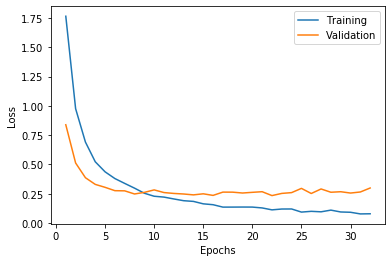

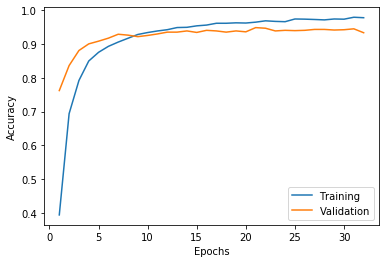

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1, len(best_history.history['val_accuracy']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, history.history['accuracy'])
    plt.plot(x_plot, history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(best_history)

In [0]:
from sklearn.metrics import classification_report

# labels_val_from_categorical = np.argmax(labels_val, axis=1)
predictions = np.argmax(best_model.predict(x_val), axis=1)
print(classification_report(labels_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       269
           1       0.92      0.91      0.92       234
           2       0.95      0.90      0.92       254
           3       0.97      0.98      0.97       265
           4       0.93      0.96      0.94       263
           5       0.90      0.91      0.91       263
           6       0.86      0.90      0.88       240
           7       0.97      0.97      0.97       277
           8       0.96      0.93      0.94       283
           9       0.88      0.88      0.88       253
          10       0.97      0.96      0.96       199

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800



# Autoencoder

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

model_type = 'autoencoder'
if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

autoencoder, encoder = get_model(
    model_type=model_type, 
    tied=True,
    divide_by=[1.5, 2, 2.5, 3],
    hidden_first=512, 
    hidden_last=32, 
    noise_type=None, 
    dropout=False, 
    batch_norm=False, 
    standard=False, 
    verbose=True
)
history_autoencoder = autoencoder.fit(
    x_train, 
    labels_train,
    validation_data=(x_val, labels_val), 
    epochs=300, 
    batch_size=128, 
    callbacks=callbacks
)

<tf.Variable 'encoder_30/kernel:0' shape=(34, 32) dtype=float32>
dense_58
<tf.Variable 'dense_58_1/kernel:0' shape=(104, 34) dtype=float32>
dense_57
<tf.Variable 'dense_57_1/kernel:0' shape=(261, 104) dtype=float32>
dense_56
<tf.Variable 'dense_56_1/kernel:0' shape=(522, 261) dtype=float32>
<tf.Variable 'dense_55_1/kernel:0' shape=(784, 522) dtype=float32>
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_55 (Dense)             (None, 522)               409770    
_________________________________________________________________
dense_56 (Dense)             (None, 261)               136503    
_________________________________________________________________
dense_57 (Dense)             (None, 104)               27248     
_____________________________

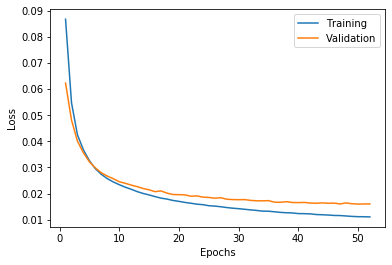

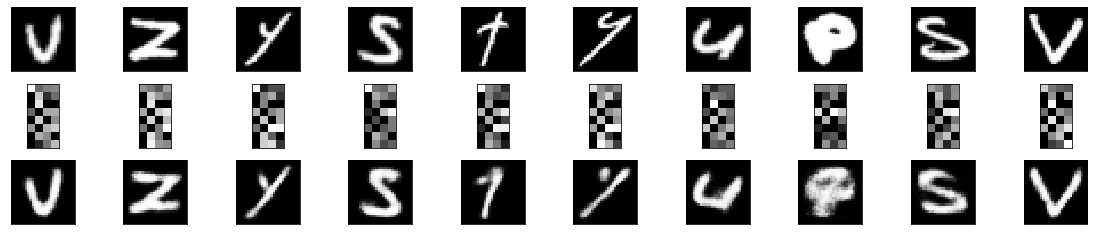

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

# print accuracy
x_plot = list(range(1, len(history_autoencoder.history['val_loss']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

plot_history(history_autoencoder)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

n=10
plt.figure(figsize=(40, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
plt.show()

## Train neural net with features learned by the autoencoder

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def get_encoder_nn(
    encoder,
    encoder_trainable=False,
    divide_by=2,
    hidden_first=128,
    hidden_last=32,
    dropout=True, 
    dropout_rate=0.3,
    batch_norm=False, 
    standard=False,
    verbose=True
):
  
  encoder.trainable = encoder_trainable
  encoder_nn = Sequential()
  encoder_nn.add(encoder)
  
  """ if isinstance(divide_by, list) and divide_by != []:
    dim = int(IMG_SHAPE / divide_by[0])
    encoder_nn.add(layers.Dense(dim, activation="relu", kernel_initializer="he_normal"))
  else:
    encoder_nn.add(layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal"))
  if dropout:
    encoder_nn.add(layers.Dropout(dropout_rate)) """
  if isinstance(divide_by, list) and divide_by != []:
    i = 0
    while i < len(divide_by) and int(dim / divide_by[i]) > hidden_last:
      if batch_norm:
        encoder_nn.add(layers.BatchNormalization())
      encoder_nn.add(layers.Dense(dim, activation="relu", kernel_initializer="he_normal"))
      if dropout:
        encoder_nn.add(layers.Dropout(dropout_rate))
      dim = int(dim / divide_by[i])
      i += 1
  else:
    while hidden_first > hidden_last:
      if batch_norm:
        encoder_nn.add(layers.BatchNormalization())
      encoder_nn.add(layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal"))
      if dropout:
        encoder_nn.add(layers.Dropout(dropout_rate))
      hidden_first = int(hidden_first / divide_by)
  encoder_nn.add(layers.Dense(N_CLASSES, activation="softmax", kernel_initializer="he_normal"))
  encoder_nn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  if verbose:
    encoder_nn.summary()
  
  return encoder_nn

In [0]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

model_type = 'nn'
if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

# define 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores_val = []
best_score = 0  # based on accuracy
best_model = None
best_history = None

for idx, (train, val) in enumerate(kfold.split(x_train, labels_train)):
  print('FOLD: ', idx + 1)
  # create model
  model = get_encoder_nn(encoder, hidden_first=32, hidden_last=32, dropout=True, encoder_trainable=False)
  # Fit the model
  history = model.fit(
      x_train[train], 
      labels_train[train], 
      validation_data=(x_train[val], labels_train[val]), 
      epochs=300, 
      batch_size=128, 
      callbacks=callbacks
  )
  # evaluate the model
  score = model.evaluate(x_val, labels_val, verbose=0)
  # save best_model
  if score[1] > best_score:  # accuracy
    best_score = score[1]
    best_model = model
    best_history = history
  print('Performance on the validation set')
  for idx in range(len(model.metrics_names)):
    print("%s: %.2f" % (model.metrics_names[idx], score[idx]))
  print()
  scores_val.append(score)
  
scores_val = np.array(scores_val)
overall_means = np.mean(scores_val, axis=0)
overall_stds = np.std(scores_val, axis=0)
for idx in range(len(overall_means)):
  print('Overall ', model.metrics_names[idx], ': ', '{:.2f}'.format(overall_means[idx]), '+-', '{:.2f}'.format(overall_stds[idx]))

FOLD:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_17 (Model)             (None, 32)                578211    
_________________________________________________________________
dense_59 (Dense)             (None, 11)                363       
Total params: 578,574
Trainable params: 363
Non-trainable params: 578,211
_________________________________________________________________
Train on 10080 samples, validate on 1120 samples
Epoch 1/300
10080/10080 [==============================] - 1s 115us/sample - loss: 14.0545 - acc: 0.0589 - val_loss: 6.4689 - val_acc: 0.1143
Epoch 2/300
10080/10080 [==============================] - 0s 32us/sample - loss: 5.3876 - acc: 0.1374 - val_loss: 4.5079 - val_acc: 0.1482
Epoch 3/300
10080/10080 [==============================] - 0s 32us/sample - loss: 4.2366 - acc: 0.1738 - val_loss: 3.7023 - val_acc: 0.2250
Epoch 4/300
10080/10080 [=====

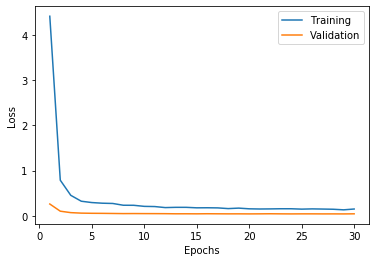

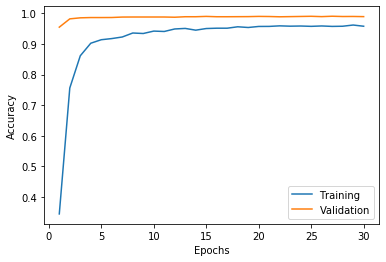

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1, len(best_history.history['val_accuracy']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, history.history['accuracy'])
    plt.plot(x_plot, history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(best_history)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(labels_val, best_model.predict_classes(x_val)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       271
           1       0.90      0.90      0.90       262
           2       0.92      0.94      0.93       244
           3       0.99      0.98      0.99       260
           4       0.95      0.92      0.94       273
           5       0.91      0.91      0.91       251
           6       0.88      0.91      0.89       235
           7       0.96      0.96      0.96       273
           8       0.96      0.95      0.96       254
           9       0.92      0.89      0.90       289
          10       0.94      0.95      0.95       188

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800



# Autoencoder tied with the classifier

In [0]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

model_type = 'autoencoder_nn'
if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

# define 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores_val = []
best_score = 0  # based on accuracy
best_model = None
best_history = None

for idx, (train, val) in enumerate(kfold.split(x_train, labels_train[0])):
  print('FOLD: ', idx + 1)
  # create model
  autoencoder_nn, _ = get_model(
      model_type=model_type, 
      divide_by=2, 
      hidden_first=512, 
      hidden_last=32, 
      dropout=True, 
      batch_norm=False, 
      standard=False, 
      verbose=True
  )
  # Fit the model
  history = autoencoder_nn.fit(
      x_train[train], 
      [labels_train[0][train], labels_train[1][train]], 
      validation_data=(x_train[val], [labels_train[0][val], labels_train[1][val]]), 
      epochs=300, 
      batch_size=128, 
      callbacks=callbacks
  )
  # evaluate the model
  score = autoencoder_nn.evaluate(x_val, labels_val, verbose=0)
  # save best_model
  if score[3] > best_score:  # classifier accuracy
    best_score = score[3]
    best_model = autoencoder_nn
    best_history = history
  print('Performance on the validation set')
  for idx in range(len(autoencoder_nn.metrics_names)):
    print("%s: %.2f" % (autoencoder_nn.metrics_names[idx], score[idx]))
  print()
  scores_val.append(score)
  
scores_val = np.array(scores_val)
overall_means = np.mean(scores_val, axis=0)
overall_stds = np.std(scores_val, axis=0)
for idx in range(len(overall_means)):
  print('Overall ', autoencoder_nn.metrics_names[idx], ': ', '{:.2f}'.format(overall_means[idx]), '+-', '{:.2f}'.format(overall_stds[idx]))

FOLD:  1
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_177 (Dense)               (None, 512)          401920      input_19[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 512)          0           dense_177[0][0]                  
__________________________________________________________________________________________________
dense_178 (Dense)               (None, 256)          131328      dropout_5[0][0]                  
__________________________________________________________________________________

## Plot decoder reconstructed images

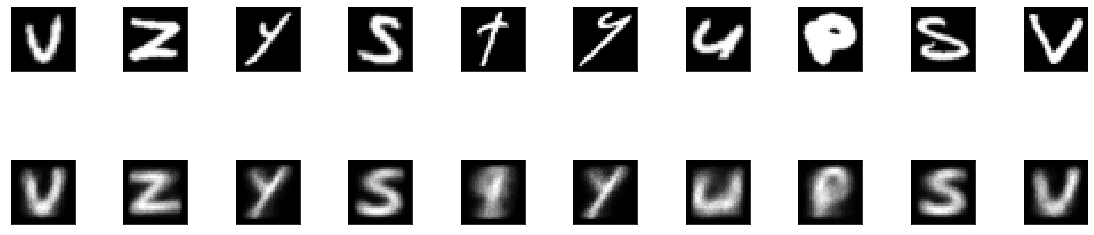

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

_, decoded_imgs = autoencoder_nn.predict(x_test)

n=10
plt.figure(figsize=(40, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
plt.show()

## Plot performances plots

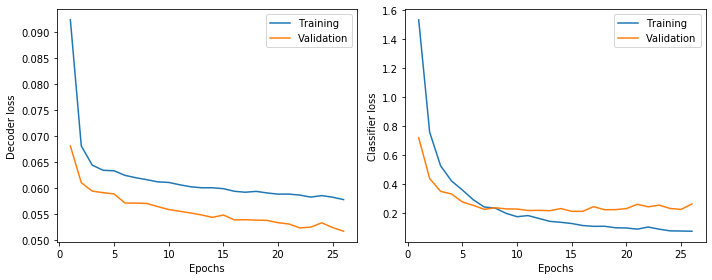

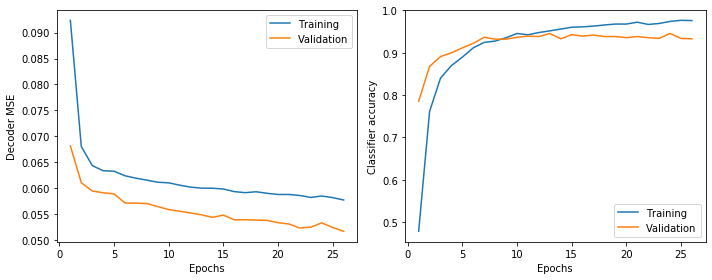

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1, len(best_history.history['val_classifier_accuracy']) + 1))

def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Decoder loss')
    plt.plot(x_plot, history.history['decoder_loss'])
    plt.plot(x_plot, history.history['val_decoder_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Classifier loss')
    plt.plot(x_plot, history.history['classifier_loss'])
    plt.plot(x_plot, history.history['val_classifier_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.tight_layout()
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Decoder MSE')
    plt.plot(x_plot, history.history['decoder_mse'])
    plt.plot(x_plot, history.history['val_decoder_mse'])
    plt.legend(['Training', 'Validation'])
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Classifier accuracy')
    plt.plot(x_plot, history.history['classifier_accuracy'])
    plt.plot(x_plot, history.history['val_classifier_accuracy'])
    plt.legend(['Training', 'Validation'])
    
    plt.tight_layout()
    plt.show()

plot_history(best_history)

In [0]:
from sklearn.metrics import classification_report

labels, _ = autoencoder_nn.predict(x_val)
print(classification_report(labels_val[0], np.argmax(labels, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       271
           1       0.90      0.93      0.92       262
           2       0.95      0.92      0.94       244
           3       0.99      0.99      0.99       260
           4       0.93      0.92      0.93       273
           5       0.92      0.94      0.93       251
           6       0.89      0.89      0.89       235
           7       0.95      0.98      0.97       273
           8       0.96      0.94      0.95       254
           9       0.90      0.89      0.89       289
          10       0.96      0.95      0.96       188

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800



# Tied autoencoders

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses

def rmse(y_true, y_pred):
  return K.sqrt(losses.mse(y_true, y_pred))

def tanh_crossentropy(y_true, y_pred):
  return -0.5 * ((1 - y_true) * K.log(1 - y_pred) + (1 + y_true) * K.log(1 + y_pred))

def get_tied_model(
    model_type='autoencoder_nn',
    divide_by=2,
    hidden_first=256,
    hidden_last=64,
    dropout=True, 
    dropout_rate=0.3,
    batch_norm=False, 
    noise_type=None,
    salt_pepper_noise_ratio=0.3, 
    gaussian_noise_std=0.5,
    standard=False,
    verbose=True
):
  
  input_layer = layers.Input(shape=(IMG_SHAPE, ))
  
  if model_type == 'autoencoder' or model_type == 'autoencoder_nn':
    if noise_type is not None:
      # noisy layer
      if noise_type == 'gaussian':  # Gaussian
        noise_layer = layers.GaussianNoise(gaussian_noise_std)(input_layer)
      elif noise_type == 'saltpepper':  # Salt and pepper
        noise_layer = SaltPepperNoise(ratio=salt_pepper_noise_ratio)(input_layer)
      if standard:
        noise_layer = StandardizeLayer(mean, std)(noise_layer)
      if isinstance(divide_by, list) and divide_by != []:
        dim = int(IMG_SHAPE / divide_by[0])
        dims = [dim]
        encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(noise_layer)
      else:
        encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(noise_layer)
    elif standard:
      encode = StandardizeLayer(mean, std)(input_layer)
      if dropout:
          encode = layers.Dropout(dropout_rate)(encode) 
    else:
      if dropout:
        encode = layers.Dropout(dropout_rate)(input_layer)
        if isinstance(divide_by, list) and divide_by != []:
          dim = int(IMG_SHAPE / divide_by[0])
          dims = [dim]
          encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(encode)
        else:
          encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
      else:
        if isinstance(divide_by, list) and divide_by != []:
          dim = int(IMG_SHAPE / divide_by[0])
          dims = [dim]
          encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(input_layer)
        else:
          encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(input_layer)

  # encoder
  if isinstance(divide_by, list) and divide_by != []:
    # saved_hidden_first = hidden_first
    # if noise_type or standard:
    #  encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
    i = 1
    while i < len(divide_by) and int(dim / divide_by[i]) > hidden_last:
      dim = int(dim / divide_by[i])
      dims.insert(0, dim)
      encode = layers.Dense(dim, activation="relu", kernel_initializer="he_normal")(encode)
      if batch_norm:
        encode = layers.BatchNormalization()(encode)
      i += 1
  else:
    saved_hidden_first = hidden_first
    # if noise_type or standard:
    #  encode = layers.Dense(hidden_first, activation ="relu", kernel_initializer="he_normal")(encode)
    while hidden_first > hidden_last * divide_by:
      hidden_first = int(hidden_first / divide_by)
      encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(encode)
      if batch_norm:
        encode = layers.BatchNormalization()(encode)
  encode = layers.Dense(hidden_last, activation ="relu", kernel_initializer="he_normal", name='encoder')(encode)
  encoder = Model(inputs=input_layer, outputs=encode)

  # decoder
  i = len(encoder.layers) - 2
  end = 1 if not dropout else 2
  decode = DenseTranspose(encoder.layers[-1], activation='relu')(encode) 
  while i > end:
    print(encoder.layers[i].name)
    if 'dense' in encoder.layers[i].name:
      decode = DenseTranspose(encoder.layers[i], activation='relu')(decode) 
    i -= 1
  decode = DenseTranspose(encoder.layers[i], activation='sigmoid', name='decoder')(decode)

  outputs = [decode]
  if model_type == 'autoencoder_nn':
    # classifier
    classifier = layers.Dense(N_CLASSES, activation="softmax", name='classifier')(encode)
    outputs.insert(0, classifier)

  # model
  model = Model(inputs=input_layer, outputs=outputs)

  if len(outputs) > 1:
    loss = ["sparse_categorical_crossentropy", 'mse']
    metrics = {'classifier': 'accuracy', 'decoder': 'mse'}
  else:
    loss = 'mse'
    metrics = {'decoder': 'mse'}
  
  # print(metrics)
  model.compile(optimizer="adam", loss=loss, metrics=metrics)
  if verbose:
    model.summary()
  # print(model.metrics_names)

  return model, encoder

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

model_type = 'autoencoder'
if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

autoencoder, encoder = get_tied_model(
    model_type=model_type, 
    divide_by=[1.5, 2, 2.5],
    hidden_first=512, 
    hidden_last=32, 
    noise_type=None, 
    dropout=False, 
    batch_norm=False, 
    standard=False, 
    verbose=True
)
history_autoencoder = autoencoder.fit(
    x_train, 
    labels_train,
    validation_data=(x_val, labels_val), 
    epochs=300, 
    batch_size=128, 
    callbacks=callbacks
)

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_113 (Dense)            (None, 522)               409770    
_________________________________________________________________
dense_114 (Dense)            (None, 261)               136503    
_________________________________________________________________
dense_115 (Dense)            (None, 104)               27248     
_________________________________________________________________
encoder (Dense)              (None, 32)                3360      
_________________________________________________________________
dense_transpose_78 (DenseTra (None, 104)               3464      
_________________________________________________________________
dense_transpose_79 (DenseTra (None, 261)               275

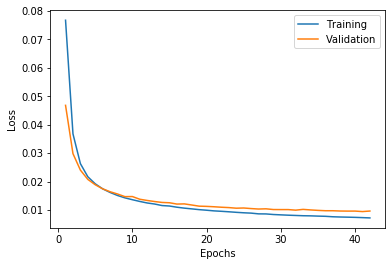

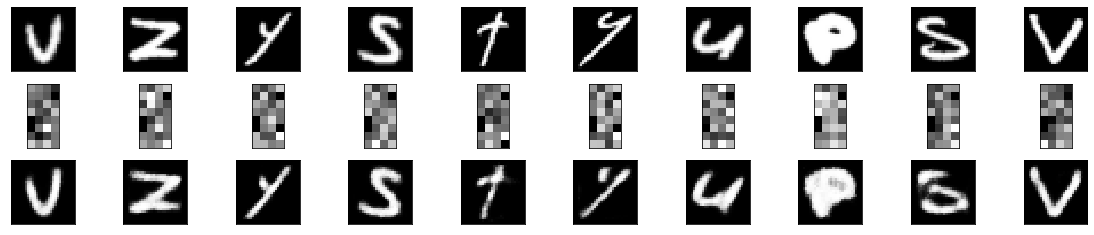

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

# print accuracy
x_plot = list(range(1, len(history_autoencoder.history['val_loss']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

plot_history(history_autoencoder)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

n=10
plt.figure(figsize=(40, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
plt.show()